# Project 1 - MAAut - André Roque

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
import pandas as pd

In [4]:
ratings_csv = np.genfromtxt('ratings.csv', delimiter=',')
ratings_csv=ratings_csv[1:]

UserID=[row[0] for row in ratings_csv]
Original_MoviesID=[row[1] for row in ratings_csv]
Ratings=[row[2] for row in ratings_csv]


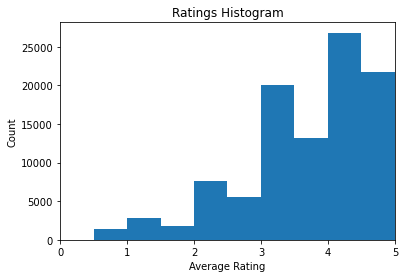

In [13]:
#Ratings Histogram

plt.xlim([0, 5])

binwidth = 0.5
plt.hist(Ratings, bins = np.arange(0, 5.0 + binwidth, binwidth))
plt.title('Ratings Histogram')
plt.xlabel('Average Rating')
plt.ylabel('Count')

plt.show()


In [15]:
#create new indexes for the movies Id's
Different_MoviesID=np.unique(Original_MoviesID)
New_MoviesID=[i for i in range(1,len(np.unique(Original_MoviesID)))]

Nb_Entries=len(UserID)
Nb_Movies=len(Different_MoviesID)
Nb_Users=len(np.unique(UserID))

Dict_MoviesID={}

for i in range(Nb_Movies):
    Dict_MoviesID[Different_MoviesID[i]]=i #The value is the new id and the key is the actual id


In [16]:
#create the matrix of the ratings with 0 representing the missing values

Ratings_Matrix=[[0 for i in range(Nb_Users)] for j in range(Nb_Movies) ]
for i in range(Nb_Entries):
    Ratings_Matrix[Dict_MoviesID[Original_MoviesID[i]]][int(UserID[i])-1]=Ratings[i]
    
#the entry i,j corresponds to the rating that the user j gave to the movie with the new id i

#create the matrix of the ratings with inputed missing values using the mean of the observed value

Ratings_Matrix_2=np.copy(Ratings_Matrix)

for i in range(Nb_Movies):
    mean=0
    n_ent=0
    for k in range(Nb_Users):
        if Ratings_Matrix_2[i][k]!=0:
            mean=mean+Ratings_Matrix_2[i][k]
            n_ent=n_ent+1
    mean=np.around(mean/n_ent,decimals=5)
    for j in range(Nb_Users):
        if Ratings_Matrix_2[i][j]==0:
            Ratings_Matrix_2[i][j]=mean





In [17]:
#Construct train and test matrices

#R-matrix to split
#p - percentage of samples in the test ([0,1])

def split(m,p,z):
    R_train=np.copy(m)
    R_test=[[0 for i in range(Nb_Users)] for j in range(Nb_Movies) ]
    Nb_Indices=round(Nb_Entries*p)
    indices=rnd.sample(range(0,Nb_Entries),Nb_Indices)
    entries=[]
    for i in indices:
        user_ind=int(UserID[i])-1
        movie_ind=Dict_MoviesID[Original_MoviesID[i]]
        R_test[movie_ind][user_ind]=R_train[movie_ind][user_ind]
        R_train[movie_ind][user_ind]=0
        entries=entries+[[movie_ind,user_ind]]
        
    return([R_train,R_test,entries])

In [18]:
#Cross validation error
#Recieves a Train and a Test matrix, and the entries for the computation of the SSE and the MSE
def CV_error(R_train, R_test, entries):
    SSE=0
    Nb_Entries=len(entries)
    for i in entries:
        user_ind=i[1]
        movie_ind=i[0]
        SSE= SSE + abs((abs(R_train[movie_ind][user_ind])-abs(R_test[movie_ind][user_ind])))**2

    SEE=(SSE/Nb_Entries)**(1/2)
    return([SSE,SEE])
    

In [19]:
#Create train and test datasets for cross validation

rnd.seed(1)
[Ratings_Matrix_Train,Ratings_Matrix_Test,Entries]=split(Ratings_Matrix, 0.1,1)
[Ratings_Matrix_Train_2,Ratings_Matrix_Test_2,Entries_2]=split(Ratings_Matrix, 0.1,1)

In [20]:
CV_error(Ratings_Matrix_Train,Ratings_Matrix_Test,Entries)

[134257.75, 3.6488269240208884]

In [21]:
CV_error(Ratings_Matrix_Train_2,Ratings_Matrix_Test,Entries)

[12869.25, 1.1296923824724425]

# SVD FACTORIZATION

In [22]:
#SVD Decompostion
SVD_R=np.linalg.svd(Ratings_Matrix,full_matrices = False)
SVD_R_2=np.linalg.svd(Ratings_Matrix_2,full_matrices = False)
SVD_R_Train=np.linalg.svd(Ratings_Matrix_Train,full_matrices = False)
SVD_R_Train_2=np.linalg.svd(Ratings_Matrix_2,full_matrices = False)

In [23]:
#Receives a R matrix and an array [U,s,V] with the respective SVD decomposition
#Returns the reconstruction error calculated using the 'norm' and the respective best aproximation matrix of R with rank k

def SVD_pred(R,SVD,k,norm):
    [U,s,V]=SVD
    Sigma=np.copy(np.diag(s[:k]))#Create diagonal matrix
    R_k=np.around(np.dot(np.dot(U[:,:k], Sigma),V[:k, :]),decimals=5)#Create matrix Rk
    Reconstruction_error=np.linalg.norm(np.add(R,-R_k),norm)
    return[Reconstruction_error,R_k]


#  Results

In [24]:
#List of every k from 1 to 50 and until 300 with a step of 10
X=[i for i in range(1,50)]+[50+(10*i) for i in range(26)]

In [26]:
Results_SVD_R=[[SVD_pred(Ratings_Matrix,SVD_R,j,'fro')[0],[SVD_pred(Ratings_Matrix,SVD_R,j,'fro')[1]]] for j in X] #For R
Results_SVD_R_2=[[SVD_pred(Ratings_Matrix_2,SVD_R_2,j,'fro')[0],[SVD_pred(Ratings_Matrix,SVD_R_2,j,'fro')[1]]] for j in X]#For R2

In [ ]:
Y1=[i[0] for i in Results_SVD_R] #Reconstruction error graph for R
Y2=[i[0] for i in Results_SVD_R_2] #Reconstruction error graph for R_2

In [ ]:
plt.subplot(1,2,1)
plt.plot(X,Y1)
plt.xlabel("Value of k")
plt.ylabel("Error")
plt.title("Reconstruction error for R")

plt.subplot(1, 2, 2)
plt.plot(X,Y2)
plt.xlabel("Value of k")
plt.ylabel("Error")
plt.title("Reconstruction error for R2")

plt.tight_layout()
plt.show()

In [165]:
Results_SVD_CV_R=[CV_error(SVD_pred(Ratings_Matrix_Train,SVD_R_Train,k,'fro')[1],Ratings_Matrix_Test,Entries) for k in X]

In [162]:
Results_SVD_CV_R_2=[CV_error(SVD_pred(Ratings_Matrix_Train_2,SVD_R_Train_2,k,'fro')[1],Ratings_Matrix_Test_2,Entries_2) for k in X]

In [166]:
YCV=[i[0] for i in Results_SVD_CV_R]
YCV2=[i[0] for i in Results_SVD_CV_R_2]

YCV_M=[i[1] for i in Results_SVD_CV_R]
YCV_M2 =[ i[1] for i in Results_SVD_CV_R_2]

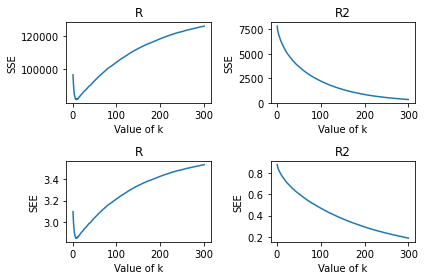

In [167]:
plt.title("Cross Validation Errors for R and R2")

plt.subplot(2,2,1)
plt.plot(X,YCV)
plt.xlabel("Value of k")
plt.ylabel("SSE")
plt.title("R")

plt.subplot(2,2,2)
plt.plot(X,YCV2)
plt.xlabel("Value of k")
plt.ylabel("SSE")
plt.title("R2")

plt.subplot(2,2,3)
plt.plot(X,YCV_M)
plt.xlabel("Value of k")
plt.ylabel("SEE")
plt.title("R")


plt.subplot(2,2,4)
plt.plot(X,YCV_M2)
plt.xlabel("Value of k")
plt.ylabel("SEE")
plt.title("R2")

plt.tight_layout()

plt.show()


# Alternated Least Squares 

In [721]:
#Alternated Least Squares
#Recieves a matrix R, the value of rank k, and applies the alrotihm described until it reaches a maximum number of iterations n
#or until the norm of the difference between each iteration if inferior to e; Outputs the matrix resulting from the last
#iteration

def ALS(R,k,n,e,norm):
    X=[[np.random.randint(1,5) for i in range(k)] for j in range(Nb_Movies)]
    Y=[[np.random.randint(1,5) for i in range(Nb_Users)] for j in range(k)]
    #print(X[0])
    err1=np.linalg.norm(np.add(R,-np.dot(X,Y)),norm)
    err2=0
    diff=abs(err2-err1)
    it=0
    while it<n and diff>e:
        err1=err2
        Y=np.around(np.dot(np.dot(np.linalg.inv((np.dot(np.transpose(X),X))),np.transpose(X)),R),decimals=3)
        X=np.around(np.dot(R,np.dot(np.transpose(Y),np.linalg.inv(np.dot(Y,np.transpose(Y))))),decimals=3)
        err2=np.around(np.linalg.norm(np.add(R,-np.dot(X,Y)),norm),decimals=4)
        diff=abs(err2-err1)
        it+=1
    if it==n:
        print('Nº of iterations exceeded')
    R_k=np.dot(X,Y)
    err=np.linalg.norm(np.add(R,-R_k),norm)
    return([R_k,err])
            

In [21]:
#Test
#ALS(Ratings_Matrix,500,10,1,'fro')

In [722]:
Y_ALS_Results=[ALS(Ratings_Matrix,k,10,10,'fro') for k in X]
Y_ALS_Results_2=[ALS(Ratings_Matrix_2,k,10,10,'fro') for k in X]


In [723]:
Y1_ALS=[i[1] for i in Y_ALS_Results]
Y2_ALS=[i[1] for i in Y_ALS_Results_2]

In [34]:
Y_ALS_Results_2=[ALS(Ratings_Matrix_2,k,10,10,'fro') for k in X]

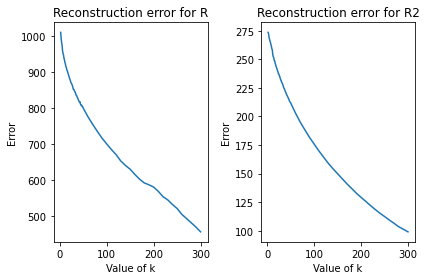

In [31]:
plt.subplot(1,2,1)
plt.plot(X,Y1_ALS)
plt.xlabel("Value of k")
plt.ylabel("Error")
plt.title("Reconstruction error for R")

plt.subplot(1, 2, 2)
plt.plot(X,Y2_ALS)
plt.xlabel("Value of k")
plt.ylabel("Error")
plt.title("Reconstruction error for R2")

plt.tight_layout()
plt.show()

In [33]:
Y_ALS_CV=[ALS(Ratings_Matrix_Train,k,10,10,'fro') for k in X]

In [32]:
Y_ALS_CV_2=[ALS(Ratings_Matrix_Train_2,k,10,10,'fro') for k in X]

In [16]:
Results_ALS_CV_R=[CV_error(i[0],Ratings_Matrix_Test,Entries) for i in Y_ALS_CV]
Results_ALS_CV_R_2=[CV_error(i[0],Ratings_Matrix_Test,Entries) for i in Y_ALS_CV_2]

In [17]:
YCV_ALS=[i[0] for i in Results_ALS_CV_R]
YCV2_ALS=[i[0] for i in Results_ALS_CV_R_2]

YCV_ALS_M=[i[1] for i in Results_ALS_CV_R]
YCV_ALS_M2 =[ i[1] for i in Results_ALS_CV_R_2]

In [38]:
min([i for i in YCV_ALS_M])

2.8658942168945885

In [40]:
min([i for i in YCV_ALS_M2])

1.271283227875269

In [27]:
YCV_ALS[5]

82823.41799594255

In [36]:
YCV2_ALS[len(X)-1]

16297.367982589698

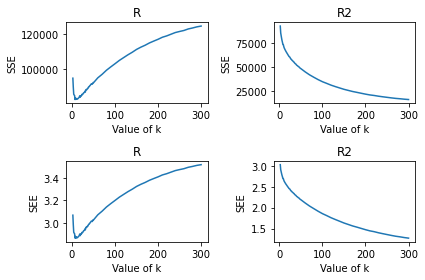

In [18]:
plt.title("Cross Validation Errors for R and R2")

plt.subplot(2,2,1)
plt.plot(X,YCV_ALS)
plt.xlabel("Value of k")
plt.ylabel("SSE")
plt.title("R")

plt.subplot(2,2,2)
plt.plot(X,YCV2_ALS)
plt.xlabel("Value of k")
plt.ylabel("SSE")
plt.title("R2")

plt.subplot(2,2,3)
plt.plot(X,YCV_ALS_M)
plt.xlabel("Value of k")
plt.ylabel("SEE")
plt.title("R")


plt.subplot(2,2,4)
plt.plot(X,YCV_ALS_M2)
plt.xlabel("Value of k")
plt.ylabel("SEE")
plt.title("R2")

plt.tight_layout()

plt.show()

# Non negative matrix factorization

In [27]:
#No sparseness constraints applied


#R -Ratings Matrix
#k - Rank of factorization
#e - error to stop
#n - nº of iterations to stop
#norm - norm used for calculating de algorithm

def NMF(R,k,e,n, norm):
    W=[[rnd.randint(1,5) for i in range(k)] for j in range(Nb_Movies)]
    H=[[rnd.randint(1,5) for i in range(Nb_Users)] for j in range(k)]
    i=0
    err1=np.linalg.norm(np.add(R,-np.dot(W,H)),norm)
    err2=0
    n1=0
    
    diff=(abs(err1-err2))
    
    while i<n and diff>e:
        err1=err2
        
        a=np.dot(np.transpose(W),R)
        b=np.add(np.dot(np.dot(np.transpose(W),W),H),10**(-10)) #Prevents division by 0
        
        H=np.multiply(H,
                     np.divide(a,b))
        H=np.around(H,decimals=5)
        
        a=np.dot(R,np.transpose(H))
        b=np.add(np.dot(np.dot(W,H),np.transpose(H)),10**(-10))
        W=np.multiply(W,np.divide ( a,b))
        
        W=np.around(W,decimals=5)
                     
                    
        err2=np.linalg.norm(np.add(R,-np.dot(W,H)),norm)
        diff=abs(err1-err2)
        i=i+1
    if i==n:
        print('Maximum number of iterations reached')
    R_k=np.dot(W,H)
    Reconstruction_error=np.linalg.norm(np.add(R,-R_k),norm)
    return([Reconstruction_error,R_k])
    

In [22]:
#Reconstruction error
Y_NMF_Results=[NMF(Ratings_Matrix,k,1,100,'fro')[0] for k in X]


In [23]:
Y_NMF_Results_2=[NMF(Ratings_Matrix_2,k,1,100,'fro')[0] for k in X]

In [211]:
max(Y_NMF_Results_2)

359.86563404488993

In [214]:
Y_NMF_Results_2[50]

359.86563404488993

In [215]:
X[50]

60

In [209]:
Y1_NMF=[i for i in Y_NMF_Results]
Y2_NMF=[i for i in Y_NMF_Results_2]

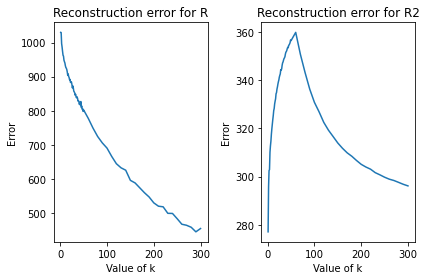

In [210]:
plt.subplot(1,2,1)
plt.plot(X,Y1_NMF)
plt.xlabel("Value of k")
plt.ylabel("Error")
plt.title("Reconstruction error for R")

plt.subplot(1, 2, 2)
plt.plot(X,Y2_NMF)
plt.xlabel("Value of k")
plt.ylabel("Error")
plt.title("Reconstruction error for R2")

plt.tight_layout()
plt.show()

In [29]:
Y_NMF_CV=[NMF(Ratings_Matrix_Train,k,1,100,'fro') for k in X]

In [26]:
Y_NMF_CV_2=[NMF(Ratings_Matrix_Train_2,k,1,100,'fro') for k in X]

In [17]:
Results_NMF_CV_R=[CV_error(i[1],Ratings_Matrix_Test,Entries) for i in Y_NMF_CV]
Results_NMF_CV_R_2=[CV_error(i[1],Ratings_Matrix_Test,Entries) for i in Y_NMF_CV_2]

In [19]:
YCV_NMF=[i[0] for i in Results_NMF_CV_R]
YCV2_NMF=[i[0] for i in Results_NMF_CV_R_2]

YCV_NMF_M=[i[1] for i in Results_NMF_CV_R]
YCV_NMF_M2 =[ i[1] for i in Results_NMF_CV_R_2]

In [23]:
[min(YCV_NMF),min(YCV2_NMF),min(YCV_NMF_M),min(YCV_NMF_M2)]

[85581.0959571481, 24600.984095551066, 2.9132147715456096, 1.5619237246083921]

In [30]:
YCV_NMF[8]

85581.0959571481

In [31]:
X[8]

9

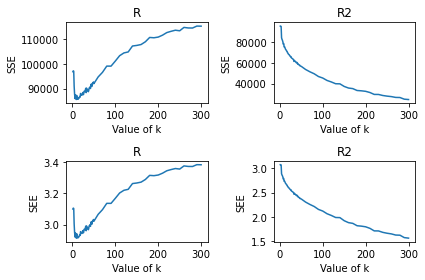

In [21]:
plt.subplot(2,2,1)
plt.plot(X,YCV_NMF)
plt.xlabel("Value of k")
plt.ylabel("SSE")
plt.title("R")

plt.subplot(2,2,2)
plt.plot(X,YCV2_NMF)
plt.xlabel("Value of k")
plt.ylabel("SSE")
plt.title("R2")

plt.subplot(2,2,3)
plt.plot(X,YCV_NMF_M)
plt.xlabel("Value of k")
plt.ylabel("SEE")
plt.title("R")

plt.subplot(2,2,4)
plt.plot(X,YCV_NMF_M2)
plt.xlabel("Value of k")
plt.ylabel("SEE")
plt.title("R2")

plt.tight_layout()

plt.show()

# Latent Space Analysis

In [30]:
movies=[Ratings_Matrix[i] for i in range(100)]

In [32]:
#Returns the mean rating for the movie at position i
def mean_class(R,i):
    mean=0
    n_ent=0
    for k in range(Nb_Users):
        if R[i][k]!=0:
            mean=mean+R[i][k]
            n_ent=n_ent+1
    mean=np.around(mean/n_ent,decimals=5)
    return(mean)

In [33]:
def SVD_proj(R,SVD,k,norm,n_movies):
    [U,s,V]=SVD
    Sigma=np.copy(np.diag(s[:k]))#Create diagonal matrix
    M = np.around(np.dot(U[:,:k], Sigma),decimals=5)#Create matrix Rk
    return M[:n_movies]

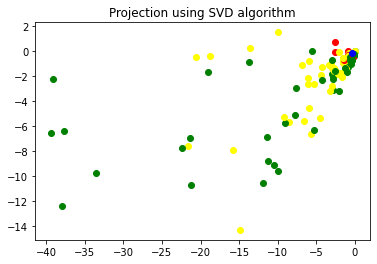

In [98]:
LS_SVD=SVD_proj(Ratings_Matrix,SVD_R,2,'fro',100)
mean1,mean2=[sum(LS_SVD[0])/100,sum(LS_SVD[1])/100]

for i in range(100):
    if mean_class(Ratings_Matrix,i)>=3.5:
        plt.scatter(LS_SVD[i][0],LS_SVD[i][1],c='green')
    elif mean_class(Ratings_Matrix,i)<=2.5:
        plt.scatter(LS_SVD[i][0],LS_SVD[i][1],c='red')
    else:
        plt.scatter(LS_SVD[i][0],LS_SVD[i][1],c='yellow')
        
        
plt.scatter(mean1,mean2,c='blue')

plt.title('Projection using SVD algorithm')
plt.show()

In [42]:
def ALS_proj(R,k,n,e,norm,n_movies):
    X=[[np.random.randint(1,5) for i in range(k)] for j in range(Nb_Movies)]
    Y=[[np.random.randint(1,5) for i in range(Nb_Users)] for j in range(k)]
    #print(X[0])
    err1=np.linalg.norm(np.add(R,-np.dot(X,Y)),norm)
    err2=0
    diff=abs(err2-err1)
    it=0
    while it<n and diff>e:
        err1=err2
        Y=np.around(np.dot(np.dot(np.linalg.inv((np.dot(np.transpose(X),X))),np.transpose(X)),R),decimals=3)
        X=np.around(np.dot(R,np.dot(np.transpose(Y),np.linalg.inv(np.dot(Y,np.transpose(Y))))),decimals=3)
        err2=np.around(np.linalg.norm(np.add(R,-np.dot(X,Y)),norm),decimals=4)
        diff=abs(err2-err1)
        it+=1
    if it==n:
        print('Nº of iterations exceeded')
        
        
    return(X[:n_movies])
            

In [85]:
LS_ALS=ALS_proj(Ratings_Matrix,2,100,1,'fro',100)
mean1,mean2=[sum(LS_ALS[0])/100,sum(LS_ALS[1])/100]


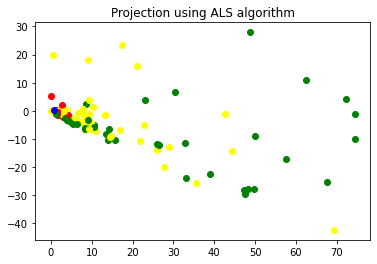

In [97]:
for i in range(100):
    if mean_class(Ratings_Matrix,i)>=3.5:
        plt.scatter(LS_ALS[i][0],LS_ALS[i][1],c='green')
    elif mean_class(Ratings_Matrix,i)<=2.5:
        plt.scatter(LS_ALS[i][0],LS_ALS[i][1],c='red')
    else:
        plt.scatter(LS_ALS[i][0],LS_ALS[i][1],c='yellow')
        
        
plt.scatter(mean1,mean2,c='blue')

plt.title('Projection using ALS algorithm')
plt.show()

In [29]:
def NMF_proj(R,k,e,n, norm, n_movies):
    W=[[np.random.randint(1,5) for i in range(k)] for j in range(Nb_Movies)]
    H=[[np.random.randint(1,5) for i in range(Nb_Users)] for j in range(k)]
    i=0
    err1=np.linalg.norm(np.add(R,-np.dot(W,H)),norm)
    err2=0
    diff=err1
    
    while i<n and diff>e:
        
        err1=err2
        
        a=np.dot(np.transpose(W),R)
        b=np.add(np.dot(np.dot(np.transpose(W),W),H),10**(-10))
        
        H=np.multiply(H,
                     np.divide(a,b))
        H=np.around(H,decimals=5)
        
        a=np.dot(R,np.transpose(H))
        b=np.add(np.dot(np.dot(W,H),np.transpose(H)),10**(-10))
        W=np.multiply(W,np.divide ( a,b))
        
        W=np.around(W,decimals=5)
        
        i=i+1
    return(W[:n_movies])

In [30]:
LS_NMF=NMF_proj(Ratings_Matrix,2,1,100, 'fro', 100)
mean1,mean2=[sum(LS_NMF[0])/100,sum(LS_NMF[1])/100]

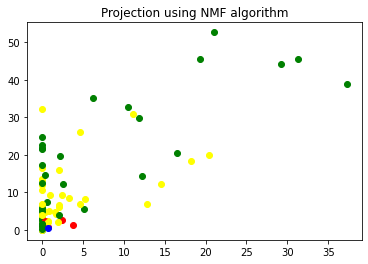

In [96]:
for i in range(100):
    if mean_class(Ratings_Matrix,i)>=3.5:
        plt.scatter(LS_NMF[i][0],LS_NMF[i][1],c='green')
    elif mean_class(Ratings_Matrix,i)<=2.5:
        plt.scatter(LS_NMF[i][0],LS_NMF[i][1],c='red')
    else:
        plt.scatter(LS_NMF[i][0],LS_NMF[i][1],c='yellow')
        
        
plt.scatter(mean1,mean2,c='blue')
plt.title('Projection using NMF algorithm')
plt.show()

In [109]:
s = pd.Series(Ratings)
s.describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
dtype: float64

In [35]:
AVG_Ratings=[mean_class(Ratings_Matrix,i) for i in range(100)]

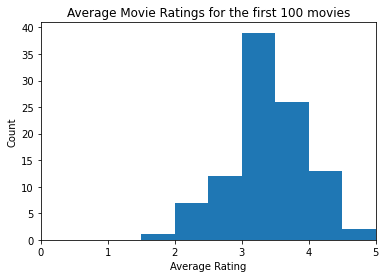

In [36]:
#Average Ratings Histogram

plt.xlim([0, 5])

binwidth = 0.5
plt.hist(AVG_Ratings, bins = np.arange(0, 5.0 + binwidth, binwidth))
plt.title('Average Movie Ratings for the first 100 movies')
plt.xlabel('Average Rating')
plt.ylabel('Count')

plt.show()